In [1]:
from __future__ import print_function
from torchvision import models, transforms, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
# from model import *
import matplotlib.pyplot as plt

/home/rich_tang/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/rich_tang/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
train_data_path = '/mnt/c/Dataset/asl-test-ir/train/'
test_data_path = '/mnt/c/Dataset/asl-alphabet/asl_alphabet_test'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_transforms = transforms.Compose([
    # transforms.Resize(32),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    # transforms.Resize(32),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [4]:
%%time
train_dataset = datasets.ImageFolder(train_data_path, transform=train_transforms)

CPU times: user 22.9 ms, sys: 11.7 ms, total: 34.6 ms
Wall time: 433 ms


In [5]:
%%time
val_dataset = datasets.ImageFolder(train_data_path, transform=test_transforms)

CPU times: user 14.7 ms, sys: 19.3 ms, total: 34 ms
Wall time: 514 ms


In [6]:
from time import time
torch.manual_seed(time())
num_train_samples = len(train_dataset)
# num_train_samples = 20000

val_split = 0.2
split = int(num_train_samples * val_split)
indices = torch.randperm(num_train_samples)


train_subset = torch.utils.data.Subset(train_dataset, indices[split:])
val_subset = torch.utils.data.Subset(val_dataset, indices[:split])

len(train_subset), len(val_subset)

(10862, 2715)

In [7]:
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_subset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=16
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_subset,
    batch_size=4,
    shuffle=False,
    pin_memory=True,
    num_workers=16
)

In [8]:
classes = train_dataloader.dataset.dataset.classes

torch.Size([64, 1, 24, 32]) torch.Size([64])
Ground Truth G
torch.Size([1, 24, 32])
torch.Size([24, 32, 1])


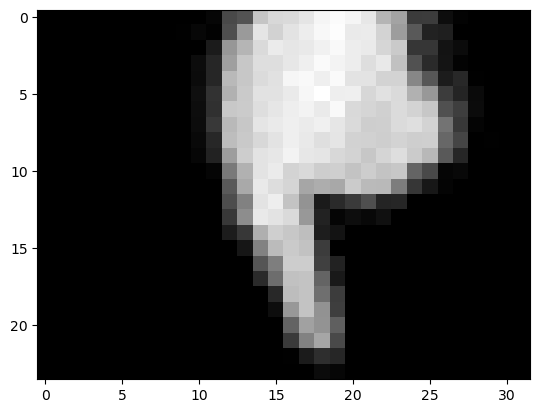

In [9]:
for img, label in train_dataloader:
    print(img.shape, label.shape)
    print(f'Ground Truth {classes[label[0]]}')
    print(img[0].size())
    print(img[0].permute(1, 2, 0).size())
    plt.imshow(img[0].permute(1, 2, 0), cmap='gray')
    break

In [10]:
model = torch.load("checkpoints-ir/checkpoint_97.57.pth", map_location='cpu')
model.eval()
print(model)

myCNN_24(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (fc): Linear(in_features=384, out_features=29, bias=False)
)


In [11]:
from pathlib import Path
from PIL import Image
test_data_path = '/mnt/c/Dataset/asl-alphabet/asl_alphabet_test'


class ASLTestDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, transforms=None):
        super().__init__()

        self.transforms = transforms
        self.imgs = sorted(list(Path(root_path).glob('*.jpg')))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('L')

        label = img_path.parts[-1].split('_')[0]
        if self.transforms:
            img = self.transforms(img)

        return img, label


test_dataset = ASLTestDataset(test_data_path, transforms=test_transforms)

In [12]:
def visualise(x, axs):
    x = x.view(-1).cpu().numpy()
    # x = [element for element in x if element > 1.]
    # x = [element for element in x if element != 0]
    axs.hist(x)

# Quantisation of Network

## Quantisation Functions

In [13]:
from collections import namedtuple

QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])


def calcScaleZeroPoint(min_val, max_val, num_bits=8):
    # Calc Scale and zero point of next
    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale = (max_val - min_val) / (qmax - qmin)

    initial_zero_point = qmin - min_val / scale

    zero_point = 0
    if initial_zero_point < qmin:
        zero_point = qmin
    elif initial_zero_point > qmax:
        zero_point = qmax
    else:
        zero_point = initial_zero_point

    zero_point = int(zero_point)

    return scale, zero_point


def calcScaleZeroPointSym(min_val, max_val, num_bits=8):

    # Calc Scale
    max_val = max(abs(min_val), abs(max_val))
    qmin = 0.
    qmax = 2.**(num_bits-1) - 1.

    scale = max_val / qmax

    return scale, 0


def quantize_tensor(x, num_bits=8, min_val=None, max_val=None):

    if not min_val and not max_val:
        min_val, max_val = x.min(), x.max()

    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale, zero_point = calcScaleZeroPoint(min_val, max_val, num_bits)
    q_x = zero_point + x / scale
    q_x.clamp_(qmin, qmax).round_()
    q_x = q_x.round().byte()

    return QTensor(tensor=q_x, scale=scale, zero_point=zero_point)


def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)


def quantize_tensor_sym(x, num_bits=8, min_val=None, max_val=None):

    if not min_val and not max_val:
        min_val, max_val = x.min(), x.max()

    max_val = max(abs(min_val), abs(max_val))
    qmin = 0.
    qmax = 2.**(num_bits-1) - 1.

    scale = max_val / qmax

    q_x = x/scale

    q_x.clamp_(-qmax, qmax).round_()
    q_x = q_x.round()
    return QTensor(tensor=q_x, scale=scale, zero_point=0)


def dequantize_tensor_sym(q_x):
    return q_x.scale * (q_x.tensor.float())

## Rework Forward pass of Linear and Conv Layers to Support Quantisation

In [14]:
def quantizeLayer(x, layer, stat, scale_x, zp_x, vis=False, axs=None, X=None, y=None, sym=False, num_bits=8):
    # for both conv and linear layers

    # cache old values
    W = layer.weight.data
    # B = layer.bias.data

    # WEIGHTS SIMULATED QUANTISED

    # quantise weights, activations are already quantised
    if sym:
        w = quantize_tensor_sym(layer.weight.data, num_bits=num_bits)
        # b = quantize_tensor_sym(layer.bias.data,num_bits=num_bits)
    else:
        w = quantize_tensor(layer.weight.data, num_bits=num_bits)
        # b = quantize_tensor(layer.bias.data, num_bits=num_bits)

    layer.weight.data = w.tensor.float()
#   layer.bias.data = b.tensor.float()

    # END WEIGHTS QUANTISED SIMULATION

    if vis:
        axs[X, y].set_xlabel("Visualising weights of this layer: ")
        visualise(layer.weight.data, axs[X, y])
        print("weight:\n", layer.weight.data.size(), layer.weight.data)

    # QUANTISED OP, USES SCALE AND ZERO POINT TO DO LAYER FORWARD PASS. (How does backprop change here ?)
    # This is Quantisation Arithmetic
    scale_w = w.scale
    zp_w = w.zero_point
#   scale_b = b.scale
#   zp_b = b.zero_point
    if stat is not None:
        if sym:
            scale_next, zero_point_next = calcScaleZeroPointSym(
                min_val=stat['min'], max_val=stat['max'])
        else:
            scale_next, zero_point_next = calcScaleZeroPoint(
                min_val=stat['min'], max_val=stat['max'])
    else:
        scale_next = 0
        zero_point_next = 0

    # Preparing input by saturating range to num_bits range.
    if sym:
        X = x.float()
        # layer.weight.data = ((scale_x * scale_w) /
        #                     scale_next)*(layer.weight.data)    # Current Question !!!!!!
        # layer.bias.data = (scale_b/scale_next)*(layer.bias.data)
    else:
        X = x.float() # - zp_x
        # layer.weight.data = ((scale_x * scale_w) /
        #                     scale_next)*(layer.weight.data - zp_w)
        # layer.weight.data = layer.weight.data - zp_w
        # layer.bias.data = (scale_b/scale_next)*(layer.bias.data + zp_b)
    
    
    
    if vis:
        axs[2, y].set_xlabel("Visualising inputs of layer: ")
        visualise(X, axs[2, y])

        
    # All int computation
    if sym:
        x = (layer(X))
    else:
        x = (layer(X)) + zero_point_next

    # cast to int
    x.round_()

    # Perform relu too
    # x = F.leaky_relu(x)

    # Reset weights for next forward pass
    layer.weight.data = W
#   layer.bias.data = B

    return x, scale_next, zero_point_next

In [15]:
def quantizeThisLayer(x, layer, vis=False, axs=None, X=None, y=None, sym=False, num_bits=8):
    # for both conv and linear layers

    # cache old values
    W = layer.weight.data
    # B = layer.bias.data

    # WEIGHTS SIMULATED QUANTISED

    # quantise weights, activations are already quantised
    if sym:
        w = quantize_tensor_sym(layer.weight.data, num_bits=num_bits)
        # b = quantize_tensor_sym(layer.bias.data,num_bits=num_bits)
    else:
        w = quantize_tensor(layer.weight.data, num_bits=num_bits)
        # b = quantize_tensor(layer.bias.data, num_bits=num_bits)

    layer.weight.data = w.tensor.float()
#   layer.bias.data = b.tensor.float()

    # END WEIGHTS QUANTISED SIMULATION

    if vis:
        axs[X, y].set_xlabel("Visualising weights of layer: ")
        visualise(layer.weight.data, axs[X, y])

    # QUANTISED OP, USES SCALE AND ZERO POINT TO DO LAYER FORWARD PASS. (How does backprop change here ?)
    # This is Quantisation Arithmetic
    scale_w = w.scale
    zp_w = w.zero_point
#   scale_b = b.scale
#   zp_b = b.zero_point

    # All int computation
    if sym:
        x = (layer(X))
    else:
        x = (layer(X))

    # cast to int
    x.round_()

    # Perform relu too
    # x = F.leaky_relu(x)

    # Reset weights for next forward pass
    layer.weight.data = W
#   layer.bias.data = B

    return x

## Get Max and Min Stats for Quantising Activations of Network
This is done by running the network with around 1000 examples and getting the average min and max activation values before and after each layer.

In [16]:
# Get Min and max of x tensor, and stores it
def updateStats(x, stats, key):
    max_val, _ = torch.max(x, dim=1)
    min_val, _ = torch.min(x, dim=1)

    # add ema calculation

    if key not in stats:
        stats[key] = {"max": max_val.sum(), "min": min_val.sum(), "total": 1}
    else:
        stats[key]['max'] += max_val.sum().item()
        stats[key]['min'] += min_val.sum().item()
        stats[key]['total'] += 1

    weighting = 2.0 / (stats[key]['total']) + 1

    if 'ema_min' in stats[key]:
        stats[key]['ema_min'] = weighting * \
            (min_val.mean().item()) + (1 - weighting) * stats[key]['ema_min']
    else:
        stats[key]['ema_min'] = weighting*(min_val.mean().item())

    if 'ema_max' in stats[key]:
        stats[key]['ema_max'] = weighting * \
            (max_val.mean().item()) + (1 - weighting) * stats[key]['ema_max']
    else:
        stats[key]['ema_max'] = weighting*(max_val.mean().item())

    stats[key]['min_val'] = stats[key]['min'] / stats[key]['total']
    stats[key]['max_val'] = stats[key]['max'] / stats[key]['total']

    return stats

# Reworked Forward Pass to access activation Stats through updateStats function


def gatherActivationStats(model, x, stats):

    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1')

    x = F.relu(model.conv1(x))

    x = F.max_pool2d(x, 2, 2)

    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv2')

    x = F.relu(model.conv2(x))

    x = F.max_pool2d(x, 2, 2)

    x = x.view(-1, 8*6*8)

    stats = updateStats(x, stats, 'fc')

    x = model.fc(x)

    return stats

# Entry function to get stats of all functions.


def gatherStats(model, test_loader):
    device = 'cuda'

    model.eval()
    test_loss = 0
    correct = 0
    stats = {}
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            stats = gatherActivationStats(model, data, stats)

    final_stats = {}
    for key, value in stats.items():
        final_stats[key] = {"max": value["max"] / value["total"], "min": value["min"] /
                            value["total"], "ema_min": value["ema_min"], "ema_max": value["ema_max"]}
    return final_stats

## Forward Pass for Quantised Inference

In [17]:
# def quantForward(model, x, stats):

#   # Quantise before inputting into incoming layers
#   x = quantize_tensor(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'])

#   x, scale_next, zero_point_next = quantizeLayer(x.tensor, model.conv1, stats['conv2'], x.scale, x.zero_point)

#   x = F.max_pool2d(x, 2, 2)

#   x, scale_next, zero_point_next = quantizeLayer(x, model.conv2, stats['fc'], scale_next, zero_point_next)

#   x = F.max_pool2d(x, 2, 2)

#   x = x.view(-1, 8 * 6 * 8)

#   # Back to dequant for final layer
#   x = dequantize_tensor(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))

#   x = model.fc(x)

#   return F.log_softmax(x, dim=1)

In [18]:
def quantForward(model, x, stats, vis=False, axs=None, sym=False, num_bits=8):
    X = 0
    y = 0
    x = QTensor(tensor=(x * 256).round(), scale=1, zero_point=0)
    # Quantise before inputting into incoming layers
#   if sym:
#     x = quantize_tensor_sym(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'], num_bits=8)
#   else:
#     x = quantize_tensor(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'], num_bits=8)

    if vis:
        axs[X, y].set_xlabel(
            'Entry into network, input distribution visualised below: ')
        visualise(x.tensor, axs[X, y])
        print("x:\n", x.tensor.size(), x.tensor)

    x, scale_next, zero_point_next = quantizeLayer(
        x.tensor, model.conv1, stats['conv2'], x.scale, x.zero_point, vis, axs, X=X, y=y+1, sym=sym, num_bits=num_bits)

    x = F.max_pool2d(x, 2, 2)

    if vis:
        axs[X+1, y+1].set_xlabel('Output after conv1 visualised below: ')
        visualise(x, axs[X+1, y+1])
        print("conv1_out:\n", x.size(), x)

    x, scale_next, zero_point_next = quantizeLayer(
        x, model.conv2, stats['fc'], scale_next, zero_point_next, vis, axs, X=X, y=y+2, sym=sym, num_bits=num_bits)

    x = F.max_pool2d(x, 2, 2)

    if vis:
        axs[X+1, y+2].set_xlabel('Output after conv2 visualised below: ')
        visualise(x, axs[X+1, y+2])
        print("conv2_out:\n", x.size(), x)

    x = x.view(-1, 8*6*8)

    x, scale_next, zero_point_next = quantizeLayer(
        x, model.fc, None, scale_next, zero_point_next, vis, axs, X=X, y=y+3, sym=sym, num_bits=num_bits)

    if vis:
        axs[X+1,y+3].set_xlabel('Output after fc visualised below: ')
        visualise(x,axs[X+1,y+3])

    # Back to dequant for final layer
    # if sym:
    #     x = dequantize_tensor_sym(
    #         QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))
    # else:
    #     x = dequantize_tensor(
    #         QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))
    
    # if vis:
    #     axs[X+1,
    #         2].set_xlabel('Output after conv2 but dequantised visualised below: ')
    #     visualise(x, axs[X+1, 2])

    # x = model.fc(x)

    # if vis:
    #     axs[X+1, 3].set_xlabel('Unquantised Weights of fc layer')
    #     visualise(model.fc.weight.data, axs[X+1, 3])

    #     axs[X+1,
    #         2].set_xlabel('Output after fc but dequantised visualised below: ')
    #     visualise(x, axs[X+1, 4])

    return x
    return F.log_softmax(x, dim=1)

# Test Function for Quantisation

In [19]:
def testQuant(model, test_loader, quant=False, stats=None, sym=False, num_bits=8):
    device = 'cuda'

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if quant:
                output = quantForward(model, data, stats,
                                      sym=sym, num_bits=num_bits)
            #   output = quantForwardFocus(model, data, stats, sym=sym, num_bits=num_bits)
            else:
                output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Get Accuaracy of Non Quantised Model

In [20]:
import copy
q_model = copy.deepcopy(model).to(device)

In [21]:
kwargs = {'num_workers': 16, 'pin_memory': True}

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    **kwargs
)

In [22]:
testQuant(q_model, val_dataloader, quant=False)


Test set: Average loss: -2.3931, Accuracy: 2696/2715 (99%)



# Gather Stats of Activations 

In [23]:
stats = gatherStats(q_model, val_dataloader)
print(stats)

{'conv1': {'max': tensor(3.9957, device='cuda:0'), 'min': tensor(4.0429e-05, device='cuda:0'), 'ema_min': -9.706920490410797e-36, 'ema_max': 1.0}, 'conv2': {'max': tensor(36.8388, device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'ema_min': 0.0, 'ema_max': 9.226389964129}, 'fc': {'max': tensor(69.7572, device='cuda:0'), 'min': tensor(0., device='cuda:0'), 'ema_min': 0.0, 'ema_max': 17.91015428514355}}


# Test Quantised Inference of Model

In [24]:
testQuant(q_model, val_dataloader, quant=True,
          stats=stats, sym=True, num_bits=4)


Test set: Average loss: -328758.2401, Accuracy: 951/2715 (35%)



# Visualise Weights and Activations

## Visualise Quantised Model

x:
 torch.Size([4, 1, 24, 32]) tensor([[[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ..., 13.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  5.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]],


        [[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ..., 31.,  8.,  0.],
          [ 0.,  0.,  0.,  ..., 26.,  1., 18.],
          [ 0.,  0.,  0.,  ..., 20.,  7.,  5.]]],


        [[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ..., 88., 41., 18.],
          [ 0.,  0.,  0.,  ..., 48., 49., 31.],
          [ 0.,  0.,  0.,  ..., 39., 31., 15.]]],


        [[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],


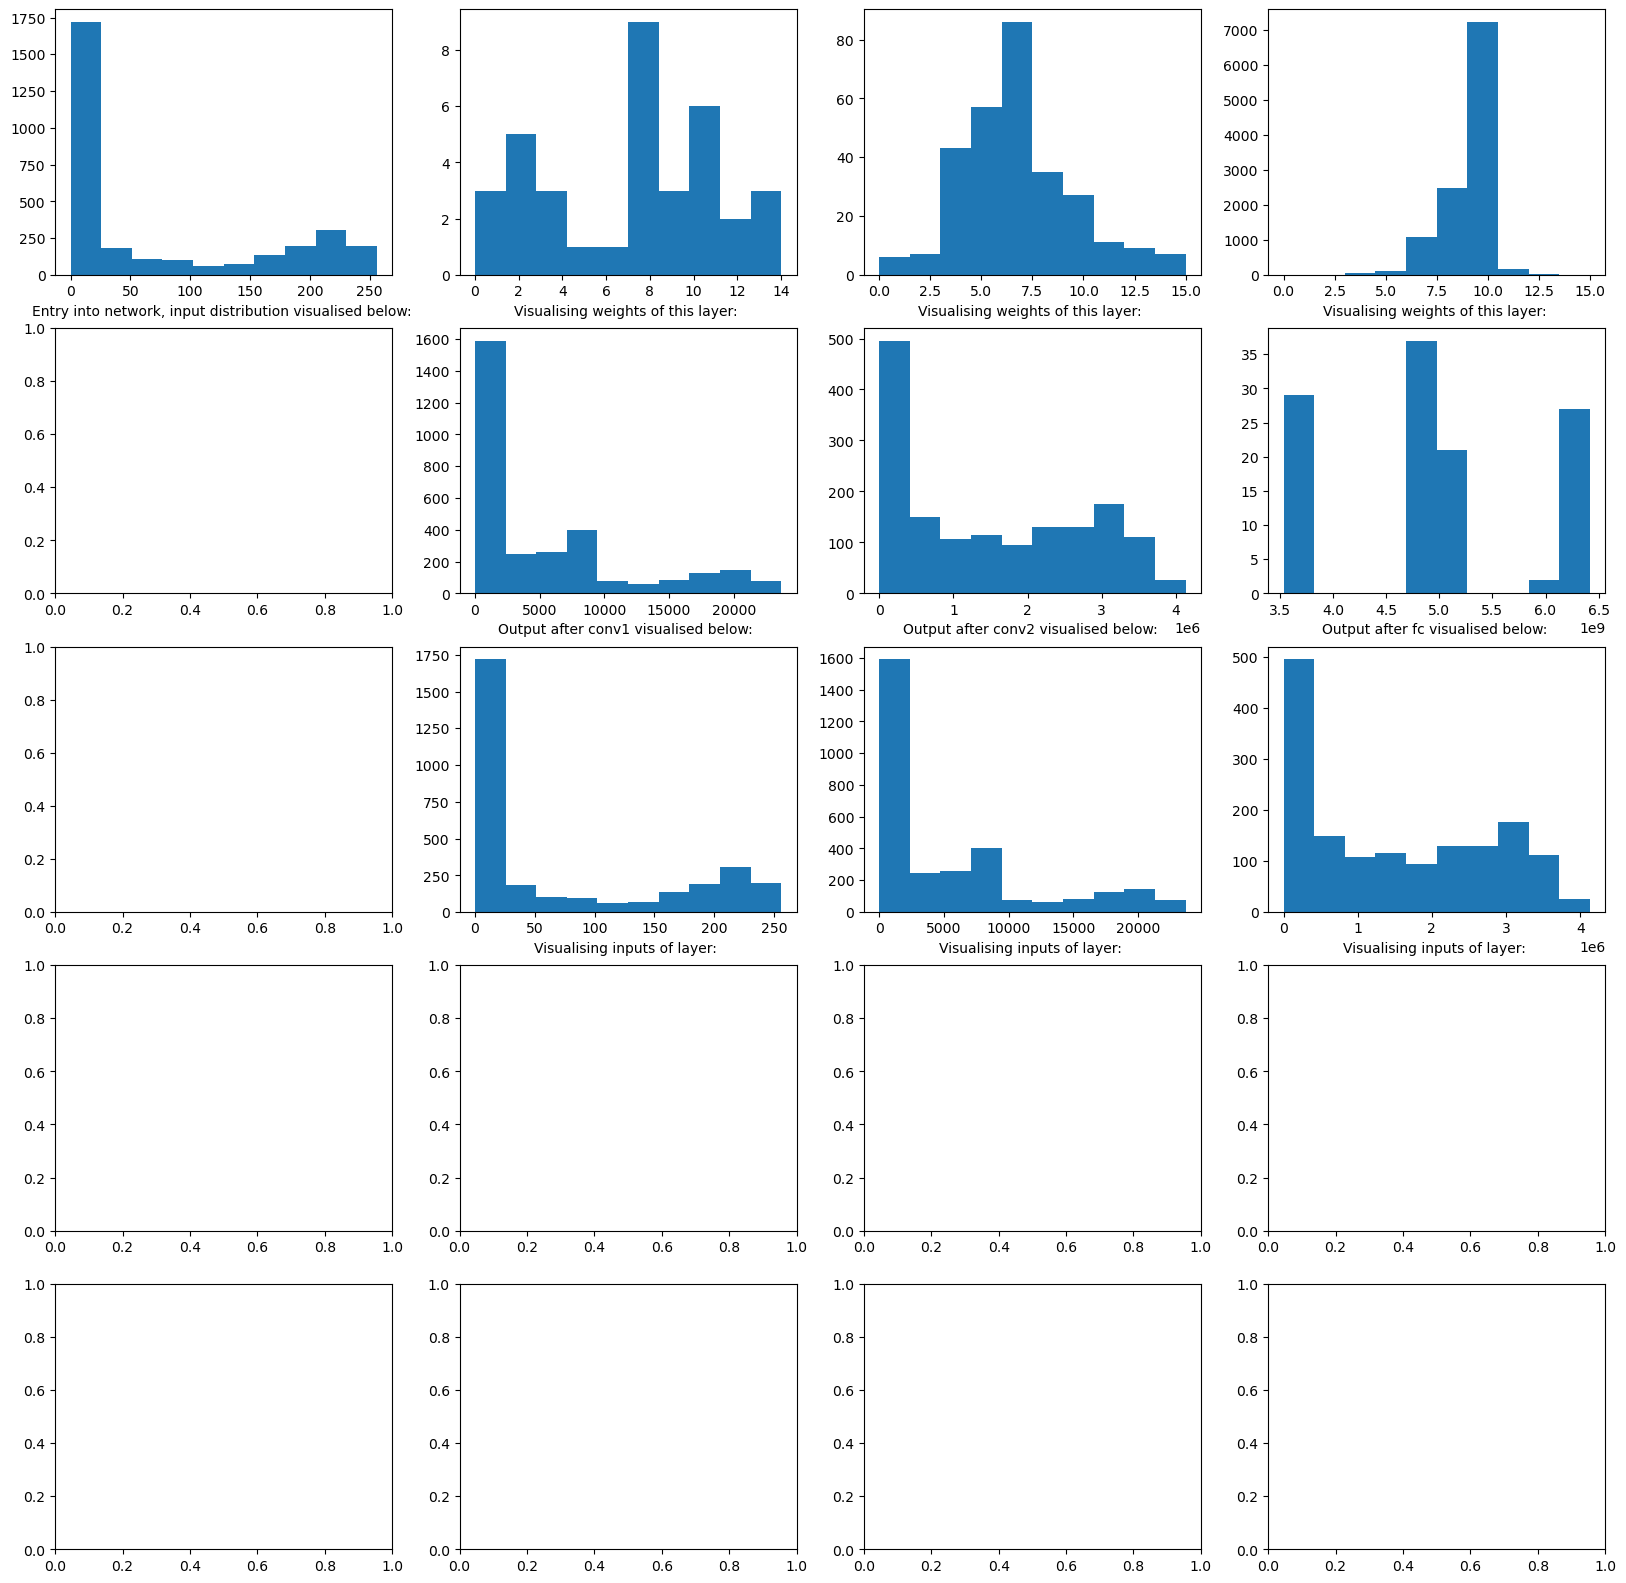

In [25]:
import matplotlib.pyplot as plt
# run through one example and plot weights and activations quantised in real time
device = 'cuda'
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
with torch.no_grad():
    for i,(data, target) in enumerate(val_dataloader):
        if i%10 != 1:
            continue
        data, target = data.to(device), target.to(device)
        output = quantForward(q_model, data, stats, vis=True,
                              axs=axs, sym=False, num_bits=4)
        break
plt.show()